In [1]:
import glob
import os
import sys

sys.path.insert(0, "..")

import pickle as pkl
import time
from itertools import cycle

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch_geometric
from sklearn.metrics import auc, roc_curve
from torch_geometric.data import Batch, Data
from torch_geometric.loader import DataListLoader, DataLoader

import awkward as ak
import fastjet
import vector

plt.style.use(hep.style.CMS)
plt.rcParams.update({"font.size": 20})

from tqdm.notebook import tqdm

%matplotlib inline

/opt/anaconda3/envs/mlpf/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [66]:
# define the global base device
world_size = torch.cuda.device_count()
multi_gpu = world_size >= 2
if world_size:
    device = torch.device("cuda:0")
    for i in range(world_size):
        print(f"Device {i}: {torch.cuda.get_device_name(i)}")
else:
    device = "cpu"
    print("Device: CPU")

Device: CPU


# Top tagging dataset

In [54]:
! ls ../../xai4hep/xai4hep/data/toptagging/*/processed

../../xai4hep/xai4hep/data/toptagging/test/processed:
data_0.pt     data_1.pt     data_2.pt     data_3.pt     data_quick.pt

../../xai4hep/xai4hep/data/toptagging/train/processed:
data_0.pt  data_10.pt data_2.pt  data_4.pt  data_6.pt  data_8.pt
data_1.pt  data_11.pt data_3.pt  data_5.pt  data_7.pt  data_9.pt

../../xai4hep/xai4hep/data/toptagging/val/processed:
data_0.pt data_1.pt data_2.pt data_3.pt


In [55]:
# load the datafiles
def load_data(dataset_path, flag, n_files=-1):
    data_files = glob.glob(f"{dataset_path}/{flag}/processed/*")
        
    data = []
    for i, file in enumerate(data_files):
        data += torch.load(f"{dataset_path}/{flag}/processed/data_{i}.pt")
        print(f"--- loaded file {i} from `{flag}` directory")
        if n_files!=-1 and i==n_files-1:
            break
                
    return data

dataset_path = "../../xai4hep/xai4hep/data/toptagging/"

data_train = load_data(dataset_path, "train", n_files=1)
data_valid = load_data(dataset_path, "val", n_files=1)
data_test = load_data(dataset_path, "val", n_files=1)

--- loaded file 0 from `train` directory
--- loaded file 0 from `val` directory
--- loaded file 0 from `val` directory


In [20]:
# number of jets
print(f"number of jets available for training: {len(data_train)}")
print(f"number of jets available for validation: {len(data_valid)}")
print(f"number of jets available for testing: {len(data_test)}")

number of jets available for training: 100001
number of jets available for validation: 100001
number of jets available for testing: 100001


In [38]:
batch_size = 10

train_loader = DataLoader(data_train, batch_size)
valid_loader = DataLoader(data_valid, batch_size)
test_loader = DataLoader(data_test, batch_size)

In [39]:
# check one batch which contains 10 jets.
# y=0 is QCD jet, and y=1 is a top quark jet

for batch in train_loader:
    break
batch

Batch(x=[474, 7], y=[10], batch=[474], ptr=[11])

In [24]:
"""
The 7 input features per particle in the jet.
    1. ∆η difference in pseudorapidity between the particle and the jet axis
    2. ∆φ difference in azimuthal angle between the particle and the jet axis
    3. log pT logarithm of the particle’s pT
    4. log E logarithm of the particle’s energy
    5. log pT/pT_jet logarithm of the particle’s pT relative to the jet pT
    6. log E/E_jet logarithm of the particle’s energy relative to the jet energy
    7. ∆R
"""

feature_dict = {
    "eta": 0,
    "phi": 1,
    "pt": 2,
    "E": 3,
    "pt/jet_pt": 4,
    "E/jet_E": 5,
    "deltaR": 6,    
}

feature_label = {
    "eta": r"Particle $\left| \eta \right|$",
    "phi": r"Particle $\left| \phi \right|$",
    "pt": r"Particle $p_T$",
    "E": "Particle E",
    "pt/jet_pt": r"Log($\frac{p_T(particle)}{p_T(jet)})$",
    "E/jet_E": r"$Log(\frac{E(particle)}{E(jet)})$",
    "deltaR": r"$\Delta R(particle, jet)$", 
    
}

In [25]:
num_features = 7

# ParticleNet

In [45]:
from typing import Callable, Union

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch_cluster import knn_graph
from torch_geometric.nn import global_mean_pool
from torch_geometric.nn.conv import MessagePassing, EdgeConv
from torch_geometric.typing import Adj, PairTensor


class EdgeConvBlock(nn.Module):
    def __init__(self, in_size, layer_size, depth):
        super(EdgeConvBlock, self).__init__()

        layers = []

        layers.append(nn.Linear(in_size * 2, layer_size))
        layers.append(nn.BatchNorm1d(layer_size))
        layers.append(nn.ReLU())

        for i in range(depth):
            layers.append(nn.Linear(layer_size, layer_size))
            layers.append(nn.BatchNorm1d(layer_size))
            layers.append(nn.ReLU())

        self.edge_conv = EdgeConv(nn.Sequential(*layers), aggr="mean")

    def forward(self, x, edge_index):
        return self.edge_conv(x, edge_index)


class ParticleNet(nn.Module):
    def __init__(
        self,
        node_feat_size,
        num_classes=1,
        k=16,
        depth=2,
        dropout=False,
    ):
        super(ParticleNet, self).__init__()

        self.node_feat_size = node_feat_size
        self.num_classes = num_classes

        self.k = k
        self.num_edge_conv_blocks = 3

        self.kernel_sizes = [self.node_feat_size, 64, 128, 256]
        self.input_sizes = np.cumsum(self.kernel_sizes)  # [4, 4+64, 4+64+128, 4+64+128+256]

        self.fc_size = 256

        if dropout:
            self.dropout = 0.1
            self.dropout_layer = nn.Dropout(p=self.dropout)
        else:
            self.dropout = None

        # define the edgeconvblocks
        self.edge_conv_blocks = nn.ModuleList()
        for i in range(0, self.num_edge_conv_blocks):
            self.edge_conv_blocks.append(EdgeConvBlock(self.input_sizes[i], self.kernel_sizes[i + 1], depth=depth))

        # define the fully connected networks (post-edgeconvs)
        self.fc1 = nn.Linear(self.input_sizes[-1], self.fc_size)
        self.fc2 = nn.Linear(self.fc_size, self.num_classes)

        self.sig = nn.Sigmoid()

    def forward(self, batch):
        x = batch.x
        y = batch.y
        batch = batch.batch

        # input transformations
        x[:, 2] = (x[:, 2] - 1.7) * 0.7  # part_pt_log
        x[:, 3] = (x[:, 3] - 2.0) * 0.7  # part_e_log
        x[:, 4] = (x[:, 4] + 4.7) * 0.7  # part_logptrel
        x[:, 5] = (x[:, 5] + 4.7) * 0.7  # part_logerel
        x[:, 6] = (x[:, 6] - 0.2) * 4.7  # part_deltaR

        edge_index = {}
        for i in range(self.num_edge_conv_blocks):
            # using only angular coords for knn in first edgeconv block
            edge_index[f"edge_conv_{i}"] = knn_graph(x[:, :2], self.k, batch) if i == 0 else knn_graph(x, self.k, batch)

            out = self.edge_conv_blocks[i](x, edge_index[f"edge_conv_{i}"])

            x = torch.cat((out, x), dim=1)  # concatenating with latent features i.e. skip connections per EdgeConvBlock

        x = global_mean_pool(x, batch)

        x = F.relu(self.fc1(x))
        if self.dropout:
            x = self.dropout_layer(x)
        x = self.fc2(x)
        x = self.sig(x)

        return x, y

In [79]:
# setup the input/output dimension of the model
num_features = 7  # we have 7 input features
num_classes = 1  # we have one output node

In [86]:
model_kwargs = {
    "node_feat_size": num_features,
    "num_classes": num_classes,
    "k": 16,
    "depth": 3,
    "dropout": True,
}

model = ParticleNet(**model_kwargs)
model.to(device)

ParticleNet(
  (dropout_layer): Dropout(p=0.1, inplace=False)
  (edge_conv_blocks): ModuleList(
    (0): EdgeConvBlock(
      (edge_conv): EdgeConv(nn=Sequential(
        (0): Linear(in_features=14, out_features=64, bias=True)
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Linear(in_features=64, out_features=64, bias=True)
        (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
        (6): Linear(in_features=64, out_features=64, bias=True)
        (7): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (8): ReLU()
        (9): Linear(in_features=64, out_features=64, bias=True)
        (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (11): ReLU()
      ))
    )
    (1): EdgeConvBlock(
      (edge_conv): EdgeConv(nn=Sequential(
        (0): Linear(in_features=142, out_feat

In [87]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

criterion = nn.BCELoss()
sig = nn.Sigmoid()

model.train()
for i, batch in tqdm(enumerate(train_loader)):
    preds, targets = model(batch.to(device))
    loss = criterion(sig(preds), targets.reshape(-1, 1).float())
    print(f"batch # {i}, loss={loss:.3f}")
    
    for param in model.parameters():
        param.grad = None
    loss.backward()
    optimizer.step()
            
    if i==10:
        break

batch # 0, loss=0.996
batch # 1, loss=0.869
batch # 2, loss=0.808
batch # 3, loss=0.759
batch # 4, loss=0.651
batch # 5, loss=0.719
batch # 6, loss=0.674
batch # 7, loss=0.678
batch # 8, loss=0.681
batch # 9, loss=0.703
batch # 10, loss=0.686



# Make ROC curves

In [88]:
def make_roc(y_test, y_score):
    fpr, tpr, _ = roc_curve(y_test, y_score)

    fig, ax = plt.subplots(figsize=(8,7))
    ax.plot(
        tpr,
        fpr,
        color="darkorange",
        lw=2,
        label=f"AUC = {round(auc(fpr, tpr)*100,2)}%",
    )
    plt.xlim([0.0, 1.0])
    plt.ylabel("False Positive Rate")
    plt.xlabel("True Positive Rate")
    plt.yscale("log")
    plt.legend(loc="lower right")

In [89]:
print("- making predictions")
y_score = None
y_test = None

model.eval()
for i, batch in tqdm(enumerate(test_loader)):

    preds, targets = model(batch.to(device))
    preds = preds.detach().cpu()

    if y_score is None:
        y_score = preds[:].detach().cpu().reshape(-1)
        y_test = targets.detach().cpu()
    else:
        y_score = torch.cat([y_score, preds[:].detach().cpu().reshape(-1)])
        y_test = torch.cat([y_test, targets.detach().cpu()])

    if i==100:
        break

- making predictions


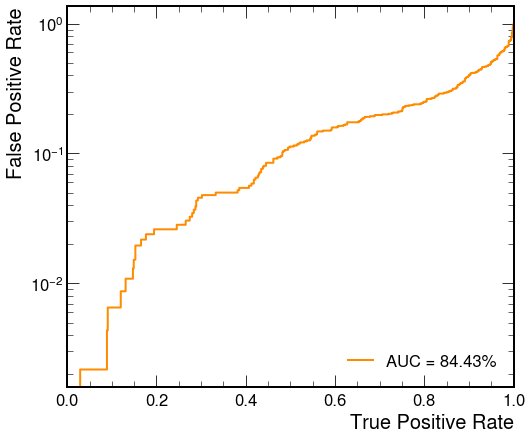

In [90]:
plt.rcParams.update({"font.size": 20})
make_roc(y_test, y_score)